In [1]:
from collections import defaultdict
from random import randint, choice, random
from tqdm import tqdm
from itertools import permutations

class Grafo():
    """
    Classe genérica para grafos, com métodos como menor caminho entre pontos A e B
    """

    def __init__(self) -> None:
        self.adj = defaultdict(dict)
        self.densidade = None


    def contarArestas(self, adj):
        return sum([len(adj[v]) for v in adj]) / 2 # Divisão por dois porque cada aresta é contada duas vezes (ida e volta)

    def vertices(self):
        return set(self.adj.keys())

    def popularAutomaticamente(self, vertices, arestas, intervalo=(1,10)):
        """
        Cria um grafo não-direcional com os vertices e arestas.
        @param vertices: int, str ou list;
            Traz os vértices que serão usados no grafo
                        int -> Os vértices serão gerados por range(vertices)
                        str -> serão usados os caracteres da string.
                                -> Aceita apenas a-zA-Z, e descarta valores duplicados.
                        list -> serão usados os elementos da lista. Descarta valores duplicados.
                                -> Devem ser hasable items, para serem transformados em set.
                        set -> Os elementos do set serão a lista
        @param arestas: float, 0 < x <= 1; 
            Representa a densidade de arestas a serem geradas automaticamente. 
            O número real será o primeiro valor possível >= ao valor informado.
            O grafo será completamente ligado, então o número mínimo de arestas é vertices-1, e o máximo é vertices!
        @param intervalo: tupla no formato (min, max) (inclusivos) para gerar aleatoriamente as distâncias entre os vértices.
        """

        if len(self.adj) != 0:
            raise Exception('O grafo já está populado. Use .limparGrafo() para apagar todo o conteúdo deste objeto.')
        
        # Transformando os vértices em set, para poder iterar sobre;
        # apesar de virarem as chaves de um dict depois, garantir que sejam hashable e remover duplicidades é bom.
        if type(vertices) == int:
            vertices = set([x for x in range(vertices)])
        elif type(vertices) == str:
            vertices = set([x for x in vertices])
        elif type(vertices) == list:
            vertices = set(vertices)
        elif type(vertices) == set:
            pass
        else:
            raise TypeError(f'Variável do tipo {type(vertices)} não é aceita. Esperava int, str ou list')

        # Dict com as listas vazias
        adj = {v:{} for v in vertices}

        # Populando até a densidade
        maxArestas = sum(range(len(vertices)))/2 # Porque como é não-direcional, serão contadas duas vezes
        minArestas = len(vertices)-1
        minPct = minArestas/maxArestas
        if minPct > arestas:
            arestas = minPct # Garantindo que o grafo será completo, quando usado com o sorted abaixo.
        #print(f'maxArestas: {maxArestas}')
        curPct = self.contarArestas(adj)/maxArestas
        #print(f'{curPct} < {arestas}')

        # Fazendo a população inicial A->B->....->N, para garantir que o grafo é conectado
        verticesSequenciais = list(vertices)
        for i in range(len(vertices)-1):
            distancia = randint(*intervalo)
            adj[verticesSequenciais[i]][verticesSequenciais[i+1]] = distancia
            adj[verticesSequenciais[i+1]][verticesSequenciais[i]] = distancia


        counterPrint = 0
        while curPct < arestas:
            # Escolhendo o primeiro dos valores
            counterPrint += 1
            if counterPrint % 10 == 0:
                print(f'{curPct*100:.2f} %', end='\r')
            A = sorted(vertices, key = lambda x: len(adj[x]))[0] # Pego um dos que tem menos, para distribuir melhor
            if len(adj[A].keys()) == len(vertices):
                A = sorted(vertices, key = lambda x: len(adj[x]), reverse=True)[0] # Pego um dos que tem menos, para distribuir melhor
            possiveisB = vertices - set(adj[A].keys())
            possiveisB.remove(A)
            B = choice(list(possiveisB))
            distancia = randint(*intervalo)
            adj[A][B] = distancia
            adj[B][A] = distancia
            
            curPct = self.contarArestas(adj)/maxArestas
            #print(f'{curPct} = {self.contarArestas(adj)}/{maxArestas}')
            #pprint(adj)
            #print(f'{curPct} < {arestas} = {curPct < arestas}')
            #input()
        self.adj = adj
            

        #Implementing Dijkstra's Algorithm
    def dijkstra(self, inicial):
        visited = {inicial : 0}
        path = defaultdict(list)

        nodes = set(self.adj.keys()) # set(graph.nodes)

        while nodes:
            minNode = None
            for node in nodes:
                if node in visited:
                    if minNode is None:
                        minNode = node
                    elif visited[node] < visited[minNode]:
                        minNode = node
            if minNode is None:
                break

            nodes.remove(minNode)
            currentWeight = visited[minNode]

            for edge in self.adj[minNode]:
                weight = currentWeight + self.adj[minNode][edge]
                if edge not in visited or weight < visited[edge]:
                    visited[edge] = weight
                    path[edge].append(minNode)
        
        return visited, path

    def preencherMenoresCaminhos(self):
        self.menoresDistancias={}
        self.melhorCaminho={}
        for v in tqdm(self.vertices()):
            self.menoresDistancias[v], self.melhorCaminho[v] = self.dijkstra(v)

    def caminho(self,x,y):
        try:
            cam = []
            while True:
                cam.append(x)
                if x == y:
                    return cam[::-1]
                x = self.melhorCaminho[y][x][0]
                
        except:
            print(self.melhorCaminho[x])
            raise Exception(f'x = {x},y = {y}')

    def MMC(self, paradas, chance = 1.):
        """
        Mínimo Melhor Caminho para passar por todas as paradas
        """
        primeiro = paradas[0]
        outras = paradas[1:]

        perms = permutations(outras)
        distanciaFinal = False
        finalPerm = None
        for perm in perms:
            perm = [primeiro] + list(perm)
            #print(perm)
            distancia = 0
            for i in range(len(perm)-1):
                distancia += self.menoresDistancias[perm[i]][perm[i+1]]
                #print(self.menoresDistancias[perm[i]][perm[i+1]],end='+')
            if not distanciaFinal:
                finalPerm = perm
                distanciaFinal = distancia
            else:
                if random() > chance:
                    return distanciaFinal, finalPerm

                if distancia < distanciaFinal:
                    distanciaFinal = distancia
                    finalPerm = perm
            #print(f'={distancia}')
        return distanciaFinal, finalPerm

    def itinerario(self, rota):
        itinerario = [rota[0]]
        for i in range(len(rota)-1):
            itinerario = itinerario + self.caminho(rota[i],rota[i+1])[1:]
        return itinerario

In [90]:
from random import choice, shuffle, choices
import copy
from tqdm import tqdm
from math import ceil
import pandas as pd
from datetime import datetime as time

class Pacote():
    """
    Item com nome, descrição, origem e destino
    """

    def __init__(self, origem, destino, grafo, nome='Nome Generico', desc='Pacote Generico') -> None:
        """
        @param origem: Nó de origem do 
        @param nome: String para identificar pacote. Puramente estético
        @param desc: Descrição do pacote. Puramente estético
        """
        self.nome = nome
        self.desc = desc
        self.origem = origem
        self.destino = destino
        self.grafo = grafo
        self.caminho = grafo.caminho(origem,destino)
        self.hash = str(self.origem) + '$' + str(self.destino)
        self.distancia = grafo.menoresDistancias[origem][destino]

    def __repr__(self) -> str:
        return f'{str(self.origem)} -> {str(self.destino)}'

    def copy(self):
        newone = type(self)(self.origem, self.destino, self.grafo)
        newone.__dict__.update(self.__dict__)
        return newone 
        


class Caminhao():
    """
    Cromossomo do nosso algoritmo genético
    """

    def __init__(self, pacotes, grafo, capacidade = 50, curMMC = None) -> None:
        self.pacotes = pacotes
        self.capacidade = capacidade
        self.grafo = grafo
        if curMMC is None and len(self.pacotes) > 0:
            #print(self.pacotes)
            curMMC = self.grafo.MMC(list(self.getParadas()),.4)
            self.melhorCaminho = curMMC[1]
        else:
            self.melhorCaminho = curMMC

    def __str__(self):
        resposta = {'pacotes':self.pacotes,
                    'capacidade':self.capacidade,
                    'melhorCaminho':self.melhorCaminho,
                    'getParadas':self.getParadas(),
                    'getItinerario':self.getItinerario(),
                    'getDistancia':self.getDistancia()}
        return str(resposta)

    def copy(self):
        copiaPacotes = [pacote.copy() for pacote in self.pacotes]
        newone = type(self)(copiaPacotes,self.grafo, self.capacidade, self.melhorCaminho)
        return newone 

    def atualizarMelhorCaminho(self):
        # Essa função é chamada aqui, em vez de um método, porque tem um componente aleatório
        paradas = list(self.getParadas())
        if len(paradas) == 0:
            self.melhorCaminho = None
        else:
            curMMC = self.grafo.MMC(paradas,.4)
            self.melhorCaminho = curMMC[1]

    def npacotes(self):
        return len(self.pacotes)

    def espacoLivre(self):
        return self.capacidade - self.npacotes()
        
    def getNumPacotesUnicos(self):
        hashes = [pacote.hash for pacote in self.pacotes]
        hashesUnicos = set(hashes)
        return len(hashesUnicos)

    def getPctPacotesUnicos(self):
        if self.npacotes() == 0:
            return 0
        return self.getNumPacotesUnicos()/self.npacotes() # Este número tem que diminuir


    def getParadas(self):
        """
        Todos os pontos únicos pelos quais o caminhão precisa passar para entregas
        """
        paradas = set()
        for pacote in self.pacotes:
            paradas.add(pacote.origem)
            paradas.add(pacote.destino)
        return paradas

    def getItinerario(self):
        if self.melhorCaminho is None:
            return None
        return self.grafo.itinerario(self.melhorCaminho)

    def getDistancia(self):

        if self.getItinerario() is None:
            return 0
        total = 0
        for i in range(len(self.getItinerario())-1):
            x, y = self.getItinerario()[i], self.getItinerario()[i+1]
            total += self.grafo.menoresDistancias[x][y]
        return total # Este número tem que diminuir


class ConjuntoDeCaminhoes():
    def __init__(self, frota, pacotes) -> None:
        self.pacotes = pacotes
        if len(frota) < 1:
            raise ValueError('A lista não pode estar vazia.')
        self.frota = frota

    def copy(self):
        copiaPacotes = []
        copiaCaminhoes = {i:self.frota[i].copy() for i in self.frota}
        for i in copiaCaminhoes:
            copiaPacotes.append(copiaCaminhoes[i].pacotes)

        newone = type(self)(copiaCaminhoes, copiaPacotes)
        return newone 
        
    def getDistanciaTotal(self):
        return sum([caminhao.getDistancia() for caminhao in self.frota.values()])
        #self.distanciaTotal = sum([caminhao.getDistancia() for caminhao in self.frota.values()])

    def adicionarPacoteAleatoriamente(self, pacote):
        caminhaoAleatorio = choice(self.frota.keys())
        caminhaoAleatorio.append(pacote)
        caminhaoAleatorio.atualizarMelhorCaminho()

class AGPI3():
    def __init__(self) -> None:
        self.fitnessGeracoes = {}        
        self.curGeracao = 0

    def gerarGrafo(self, vertices, arestas, intervalo=(1,10)):
        self.grafo = Grafo()
        self.grafo.popularAutomaticamente(vertices, arestas, intervalo)
        self.grafo.preencherMenoresCaminhos()

    def gerarPacotes(self, nPacotes=40, origem = None):
        pacotes = []
        print('Gerando pacotes:')
        for _ in tqdm(range(nPacotes)):            
            if origem is None:
                origem = choice(list(self.grafo.vertices()))
            destino = choice(list(self.grafo.vertices()))
            curPacote = Pacote(origem, destino, self.grafo)
            pacotes.append(curPacote)
        return pacotes

    def gerarCaminhao(self, pacotes, capacidade = 50):
        caminhao = Caminhao(pacotes,self.grafo, capacidade = 50)
        return caminhao

    def gerarIndividuo(self, n_caminhoes, pacotes = None, origem = None, capacidade = 50):
        
        if type(pacotes) == int:
            pacotes = self.gerarPacotes(nPacotes=pacotes, origem=origem)
        elif type(pacotes) != list:
            raise(f'O tipo {type(pacotes)} não é aceito para a variável pacotes. Esperado: int, list')
        individuo = {i:self.gerarCaminhao(pacotes[i::n_caminhoes], capacidade) for i in range(n_caminhoes)}
        return ConjuntoDeCaminhoes(individuo, pacotes)

    def gerarPopulacao(self, n_individuos, n_caminhoes, pacotes = None, origem=None, capacidade = 50):
        pop = []
        for _ in tqdm(range(n_individuos)):
            pop.append(self.gerarIndividuo(n_caminhoes,pacotes=pacotes,origem=origem, capacidade = capacidade))
        self.pop = pop
        # Reset desses valores ao gerar nova população, pra poder usar o mesmo conjunto de pacotes.
        self.fitnessGeracoes = {}        
        self.curGeracao = 0


    # CLASSES DE TREINAMENTO
    def fitness(self, ind):
        # Para o caminhao -> diminuir o percentual único
        # Para o individuo -> diminuir a distanciaTotal
        
        somaPctUnico = sum([caminhao.getPctPacotesUnicos() for caminhao in ind.frota.values()])
        nCaminhoes = len(ind.frota)
        somaPonderada = somaPctUnico/nCaminhoes

        listaParadas = [caminhao.getParadas() for caminhao in ind.frota.values() if caminhao.getParadas()]
        intersection = set.intersection(*listaParadas)
        union = set.union(*listaParadas)
        pctIntersection = len(intersection)/len(union)
        result = ind.getDistanciaTotal() * (1 + somaPonderada/5 + pctIntersection/5)
        #print(f'{ind.getDistanciaTotal():.2f} * (1 + {somaPonderada:.2f} + {pctIntersection:.2f}) = {result:.2f}')
        #return ind.getDistanciaTotal()
        return result

    def crossover(self, caminhao1, caminhao2, origem = None):
        for p1 in caminhao1.getParadas():
            if p1 == origem:
                continue
            if p1 in caminhao2.getParadas():
                for i,pacote in enumerate(caminhao2.pacotes):
                    if caminhao1.espacoLivre() < 1:
                        break
                    if (pacote.origem == p1) or (pacote.destino == p1):
                        troca = caminhao2.pacotes.pop(i)
                        caminhao1.pacotes.append(troca)
        #print(f'Caminhao 1:')
        #print(caminhao1)
        caminhao1.atualizarMelhorCaminho()
        #print(f'Caminhao 2:')
        #print(caminhao2)
        caminhao2.atualizarMelhorCaminho()

    def mutacao(self, caminhao):
        if caminhao.melhorCaminho is not None:
            if len(caminhao.melhorCaminho) > 3:    
                comeco = caminhao.melhorCaminho[0]
                fim = caminhao.melhorCaminho[-1]
                to_shuffle = caminhao.melhorCaminho[1:-1]
                shuffle(to_shuffle)
                caminhao.melhorCaminho = [comeco] + to_shuffle + [fim]


    def individuoMutacao(self, cjDeRotas):
        #print([cam.melhorCaminho for cam in cjDeRotas.frota.values()])
        start = time.now()
        #cur = copy.deepcopy(cjDeRotas)
        cur = cjDeRotas.copy()
        end = time.now()
        #print('>>[MUTACAO]cur = copy.deepcopy(cjDeRotas) ',end-start)
        start = end
        #print([cam.melhorCaminho for cam in cur.frota.values()])
        chosenIndex = choice([x for x in cur.frota])
        self.mutacao(cur.frota[chosenIndex])
        end = time.now()
        #print('>>[MUTACAO]self.mutacao(cur.frota[chosenIndex]) ',end-start)
        start = end
        #print([cam.melhorCaminho for cam in cur.frota.values()])
        return cur

    def individuoCrossover(self, cjDeRotas, origem = None):
        #print([cam.getParadas() for cam in cjDeRotas.frota.values()])
        start = time.now()
        #cur = copy.deepcopy(cjDeRotas)
        cur = cjDeRotas.copy()
        end = time.now()
        #print('>>[CROSSOVER]cur = copy.deepcopy(cjDeRotas) ',end-start)
        start = end
        #print([cam.getParadas() for cam in cur.frota.values()])
        chosenIndex1 = choice([x for x in cur.frota])
        chosenIndex2 = choice([x for x in cur.frota])
        while chosenIndex1 == chosenIndex2:
            chosenIndex2 = choice([x for x in cur.frota])
        end = time.now()
        #print('>>[CROSSOVER]while chosenIndex1 == chosenIndex2: ',end-start)
        start = end
        self.crossover(cur.frota[chosenIndex1],cur.frota[chosenIndex2],origem)
        end = time.now()
        #print('>>[CROSSOVER]self.crossover(cur.frota[chose...: ',end-start)
        start = end
        #print([cam.getParadas() for cam in cur.frota.values()])
        return cur

    def proxGeracao(self, origem = None, pctCrossover = 1. , pctMutacao = 1.):
        start = time.now()
        curPop = self.pop        
        n_individuos = len(self.pop)
        
        if len(self.fitnessGeracoes) == 0:
            # Esse if é pra preencher o fitness da geração 0 antes de começar
            fitnessInicial = [self.fitness(ind) for ind in curPop]
            self.fitnessGeracoes[self.curGeracao] = fitnessInicial
            self.curGeracao += 1
        end = time.now()
        #print('if len(self.fitnessGeracoes) == 0:',end-start)
        start = end
        
        # Parte das mutações
        mutacoesPop = [self.individuoMutacao(ind) for ind in curPop if random() <= pctMutacao]
        end = time.now()
        #print('mutacoesPop = [self.individuoMutacao(ind) for ind in curPop] ',end-start)
        start = end
        # Parte dos crossover
        crossoverPop = [self.individuoCrossover(ind, origem) for ind in curPop if random() <= pctCrossover]
        end = time.now()
        #print('crossoverPop = [self.individuoCrossover(ind, origem) for ind in curPop] ',end-start)
        start = end
        conjuntoAtual = curPop + mutacoesPop + crossoverPop

        # Pegando os valores de fitness
        fitnessConjuntoAtual = [ceil(self.fitness(ind)) for ind in conjuntoAtual]
        #print(len(fitnessConjuntoAtual))
        weights = [(1+abs(max(fitnessConjuntoAtual)-fitness))**3 for fitness in fitnessConjuntoAtual] # O 1+ é para evitar que fique tudo 0 quando ficarem iguais.
        end = time.now()
        #print('weights = [(1+abs(max(fit... ',end-start)
        start = end
        
        #print('weights: ',weights)
        #print('fit: ',fitnessConjuntoAtual)
        #print('#',self.curGeracao)
        
        newPop = [choices(conjuntoAtual,weights=weights,k=1)[0] for _ in range(n_individuos)]
        fitnessAtual = [self.fitness(ind) for ind in newPop]
        #print('fitNewPop: ',fitnessAtual)
        self.fitnessGeracoes[self.curGeracao] = fitnessAtual
        self.curGeracao += 1
        end = time.now()
        #print('self.curGeracao += 1 ',end-start)
        start = end
        
        self.pop = newPop
        
    def Evoluir(self, n_geracoes=None, max_geracoes=None, min_variacao=None, 
    strikes = 3, testNum = 10, origem = None, pctCrossover = 1., pctMutacao = 1., atrasados = None):
        """
        Dois modos:
            Passando n_geracoes -> roda n_geracoes vezes, sem distinção.
            Passando max_geracoes + min_variacao -> Para assim que  OU houver variação no valor mínimo do fitness entre gerações MENOR que min_variação,
                                                                    OU houver max_geracoes iteracoes

            A preferência é dada para o primeiro método; Se n_geracoes é passado, os outros atributos são ignorados.
        """

        adicionarAtrasados = True # Essa variável é usada lá embaixo para adicionar os atrasados no primeiro primeiro strike

        start = time.now()
        if n_geracoes is not None:
            for _ in tqdm(range(n_geracoes)):
                self.proxGeracao(origem, pctCrossover = pctCrossover, pctMutacao = pctMutacao)
                #print(min(self.fitnessGeracoes[self.curGeracao-1]))
            end = time.now()
            #print('if n_geracoes is not None:',end-start)
            start = end
        else:
            if (max_geracoes is None) or (min_variacao is None):
                raise Exception(f'Como você não passou n_geracoes, max_geracoes e min_variacao não podem ser nulos.')
            strike = 0
            #for _ in tqdm(range(max_geracoes)):
            
            for _ in range(max_geracoes):
                self.proxGeracao(origem, pctCrossover = pctCrossover, pctMutacao = pctMutacao)
                end = time.now()
                #print('self.proxGeracao(origem):',end-start)
                start = end
                #print(self.curGeracao)
                #print(self.fitnessGeracoes.keys())
                # Essas atribuições podem ser feitas porque a primeira chamada de proxGeracao preenche os valores pras gerações 0 e 1
                for ind in self.pop:
                    #print([x.getParadas() for x in ind.frota.values()])
                    pass
                
                if self.curGeracao > testNum:
                    valorAnterior = sum(self.fitnessGeracoes[self.curGeracao-testNum])/len(self.fitnessGeracoes[self.curGeracao-testNum])
                    valorAtual = sum(self.fitnessGeracoes[self.curGeracao-1])/len(self.fitnessGeracoes[self.curGeracao-1])
                    #print(f'valorAnterior: {valorAnterior}; valorAtual: {valorAtual}')
                    variacao = abs(1- abs(valorAtual/valorAnterior))
                    end = time.now()
                    #print('if self.curGeracao > testNum:',end-start)
                    start = end
                else:
                    variacao = 1
                #print('Var: ',variacao)
                #print(f'Strike: {strike}')
                if variacao < min_variacao:
                    strike += 1

                    # Momento da adição dos pacotes atrasados, se houver
                    if atrasados is not None and adicionarAtrasados and strike == 1:
                        adicionarAtrasados = False
                        
                        for ind in self.pop:
                            # Escolhendo o caminhão com o maior espaço vazio
                            curAtrasados = copy.deepcopy(atrasados)
                            while True:
                                chosenIndex = choice([x for x in ind.frota]) # Indice de caminhao aleatorio
                                chosenCaminhao = ind.frota[chosenIndex]
                                #print(f'Chosen: {chosenCaminhao.pacotes}')
                                while chosenCaminhao.espacoLivre() > 0:
                                    #print(f'\t{chosenCaminhao.pacotes}')
                                    chosenCaminhao.pacotes.append(curAtrasados.pop())
                                    if len(curAtrasados) == 0:
                                        break
                                chosenCaminhao.atualizarMelhorCaminho()
                                if len(curAtrasados) == 0:
                                    break
                        

                    if strike > strikes:
                        break
                else:
                    strike = 0


In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 10]

In [76]:
vertices = 300
arestas = 0.35
npacotes = 100
capacidade = 9
n_individuos = 5
min_variacao = 0.008
strikes = 5
pctCrossover = 0.2
pctMutacao = 0.2
pctAtrasados = 0.1

In [91]:
origem = 0
agRaw = AGPI3()
agRaw.gerarGrafo(vertices=vertices,arestas=arestas)
pacotes = agRaw.gerarPacotes(npacotes,origem)

34.95 %

  2%|█▋                                                                                | 6/300 [00:00<00:05, 52.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 14323.34it/s]

Gerando pacotes:


In [92]:
max_geracoes = 500
n_caminhoes = ceil(1.2*(npacotes/capacidade))

respostas = []
for x in tqdm(range(24)):
    resDict = {
    'max_geracoes':max_geracoes,
    'capacidade':capacidade,
    'vertices':vertices,
    'npacotes':npacotes,
    'n_individuos':n_individuos,
    'n_caminhoes':n_caminhoes,
    'min_variacao':min_variacao,
    'strikes':strikes,
    'pctMutacao':pctMutacao,
    'pctCrossover':pctCrossover,
    'pctAtrasados':0}
    resDictAlguns = resDict.copy()
    resDictAlguns['pctAtrasados'] = pctAtrasados
    start = time.now()
    paiDeAlguns = copy.deepcopy(agRaw)
    paiDeTodos = copy.deepcopy(agRaw)
    algunsPacotes = pacotes[ceil(npacotes*pctAtrasados):]
    atrasados = pacotes[:ceil(npacotes*pctAtrasados)]
    paiDeTodos.gerarPopulacao(n_individuos=n_individuos,n_caminhoes=n_caminhoes,pacotes=pacotes, capacidade = capacidade)
    paiDeAlguns.gerarPopulacao(n_individuos=n_individuos,n_caminhoes=n_caminhoes,pacotes=algunsPacotes, capacidade = capacidade)
    for pctCrossover in [0.9]:
        for pctMutacao in tqdm([0.9]):
            resDictAlguns['pop'] = [cjDeRotas.copy() for cjDeRotas in paiDeAlguns.pop]
            paiDeAlguns.Evoluir(max_geracoes=max_geracoes, min_variacao=min_variacao, strikes = strikes, origem = origem, atrasados = atrasados)
            end = time.now()
            resDictAlguns['delta'] = end-start
            resDictAlguns['fitnessGeracoes'] = paiDeAlguns.fitnessGeracoes.copy()
            resDictAlguns['grafo'] = paiDeAlguns.grafo
            timestamp = str(time.now()).split('.')[0].replace('-','').replace(':','').replace(' ','')
            #respostas.append(resDictAlguns)

            resDict['pop'] = [cjDeRotas.copy() for cjDeRotas in paiDeTodos.pop]
            paiDeTodos.Evoluir(max_geracoes=max_geracoes, min_variacao=min_variacao, strikes = strikes, origem = origem)
            end = time.now()
            resDict['delta'] = end-start
            resDict['fitnessGeracoes'] = paiDeTodos.fitnessGeracoes.copy()
            resDict['grafo'] = paiDeTodos.grafo
            timestamp = str(time.now()).split('.')[0].replace('-','').replace(':','').replace(' ','')
            #respostas.append(resDict)
            #with open(f'resultados/{timestamp}.pkl','wb') as f:
            #    pickle.dump(resDict,f)
    respostas.append((paiDeTodos.fitnessGeracoes,paiDeAlguns.fitnessGeracoes))

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5002.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1670.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2508.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.30it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2505.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2507.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5012.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2505.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5000.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2493.94it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2506.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1670.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5008.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2511.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2507.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1669.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1670.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5018.31it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5015.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1251.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2506.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2504.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5006.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2506.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2509.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1677.59it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1002.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2507.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5011.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2506.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5005.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2505.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2509.76it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1670.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1251.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2507.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2504.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2510.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2504.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1002.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.38it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1672.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1670.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2505.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1252.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1672.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1252.93it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1670.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2503.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2511.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2509.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2507.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2507.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2505.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2506.46it/s]

100%|███████████████████████████

In [95]:
ls = []
for dupla in respostas:
    a = dupla[0]
    b = dupla[1]
    for i in range(len(b)-1):
        if sum(b[i+1]) > (sum(b[i])*1.1):
            added = i
            break
    a_max_ger = max(a.keys())
    b_max_ger = max(b.keys())
    a_min_val = min(a[a_max_ger])
    b_min_val = min(b[b_max_ger])
    ls.append([a_max_ger,b_max_ger,added, a_min_val,b_min_val])
resdf = pd.DataFrame(ls, columns=['gerA','gerB','added', 'minA','minB'])

In [96]:
resdf['gerAplus'] = resdf['gerA'] + resdf['added']
resdf['maisRapido'] = resdf['gerB']/resdf['gerAplus']

In [97]:
resdf.describe().iloc[1:,:]

,gerA,gerB,added,minA,minB,gerAplus,maisRapido
mean,81.13000,100.690000,36.300000,604.804940,598.367725,117.430000,0.943065
std,41.97971,37.455615,9.209679,27.516308,24.302259,43.594841,0.435554
min,30.00000,36.000000,18.000000,541.532066,539.398853,54.000000,0.258621
25%,49.75000,75.500000,29.000000,585.042297,581.042639,86.000000,0.645947
50%,72.00000,91.000000,36.000000,603.143707,599.518791,105.500000,0.821289
75%,97.25000,115.500000,42.000000,626.155644,614.462828,133.500000,1.153491
max,214.00000,250.000000,60.000000,660.329784,662.397459,255.000000,2.629630


#### df = pd.DataFrame(respostas[2].fitnessGeracoes)
df = df.melt()

df2 = pd.DataFrame(respostas[2][1].fitnessGeracoes)
df2 = df2.melt()

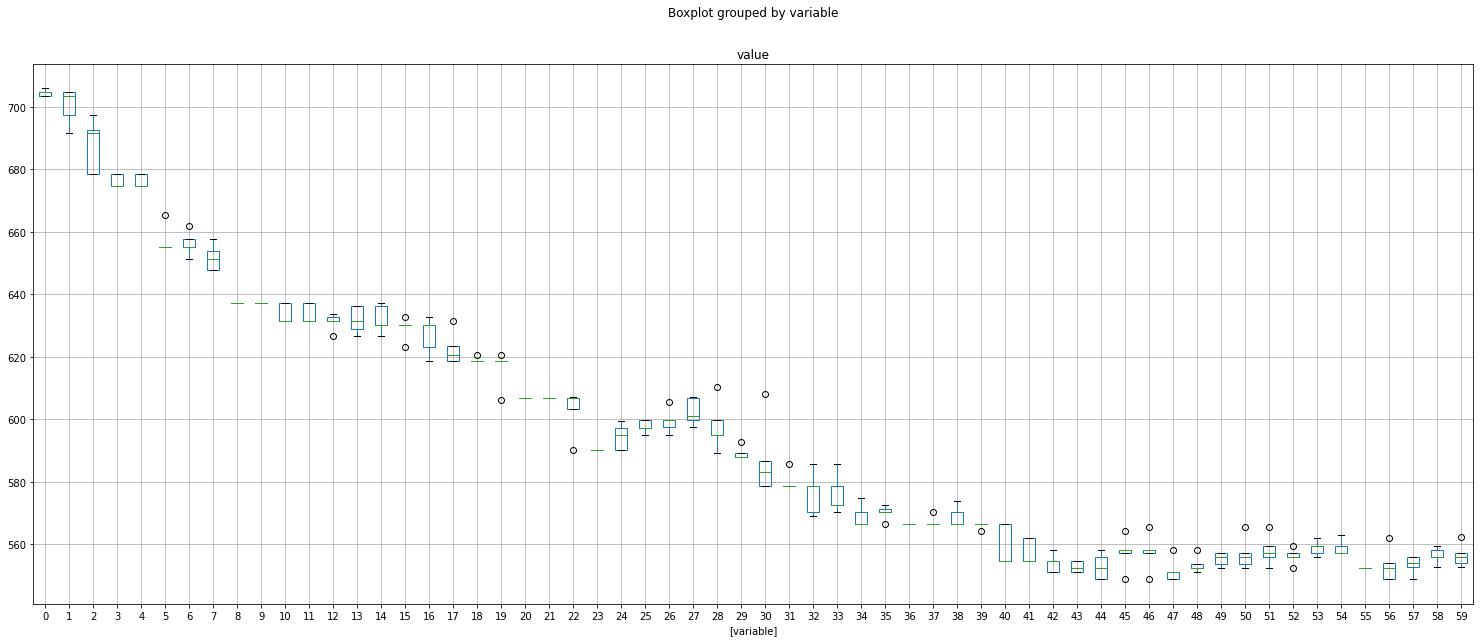

In [48]:
#fig = df.loc[((df['variable'] >= 0)&(df['variable'] <= 1000))].boxplot(by='variable').get_figure()

#fig.savefig('sem_atrasados.png')

<AxesSubplot:title={'center':'value'}, xlabel='[variable]'>

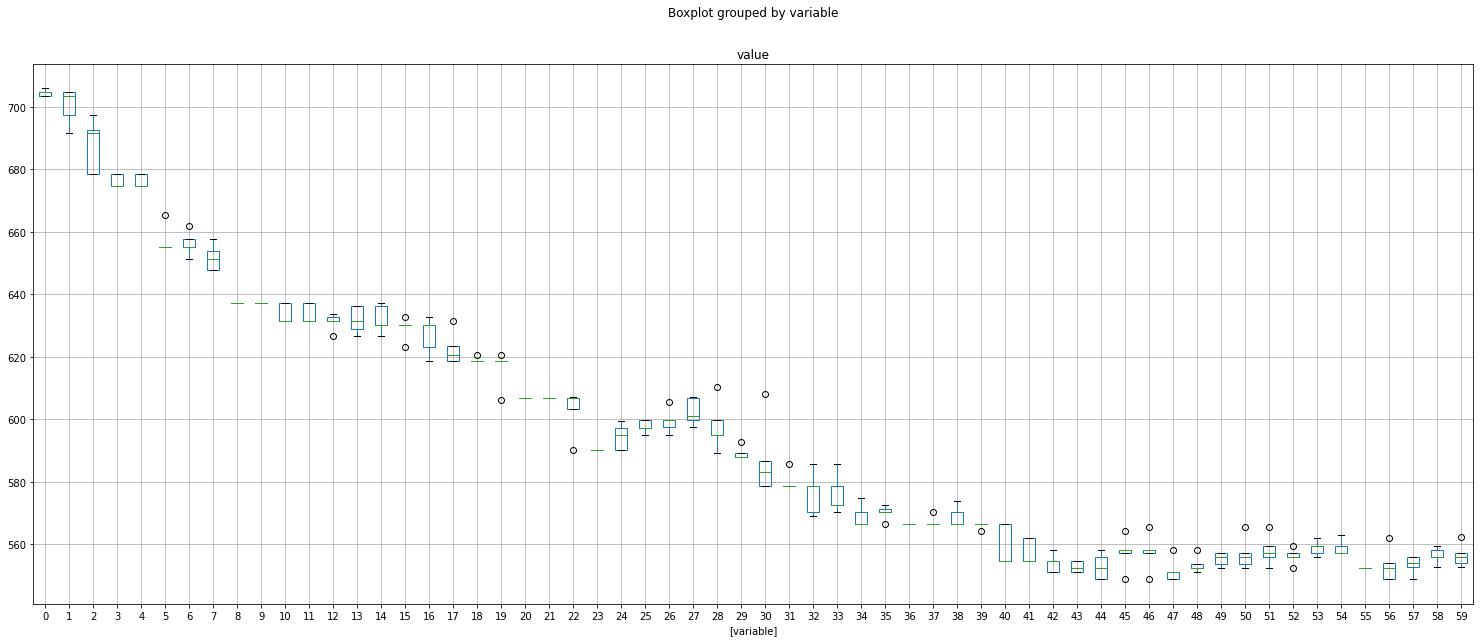

In [44]:
#df.loc[((df['variable'] >= 0)&(df['variable'] <= 1000))].boxplot(by='variable')

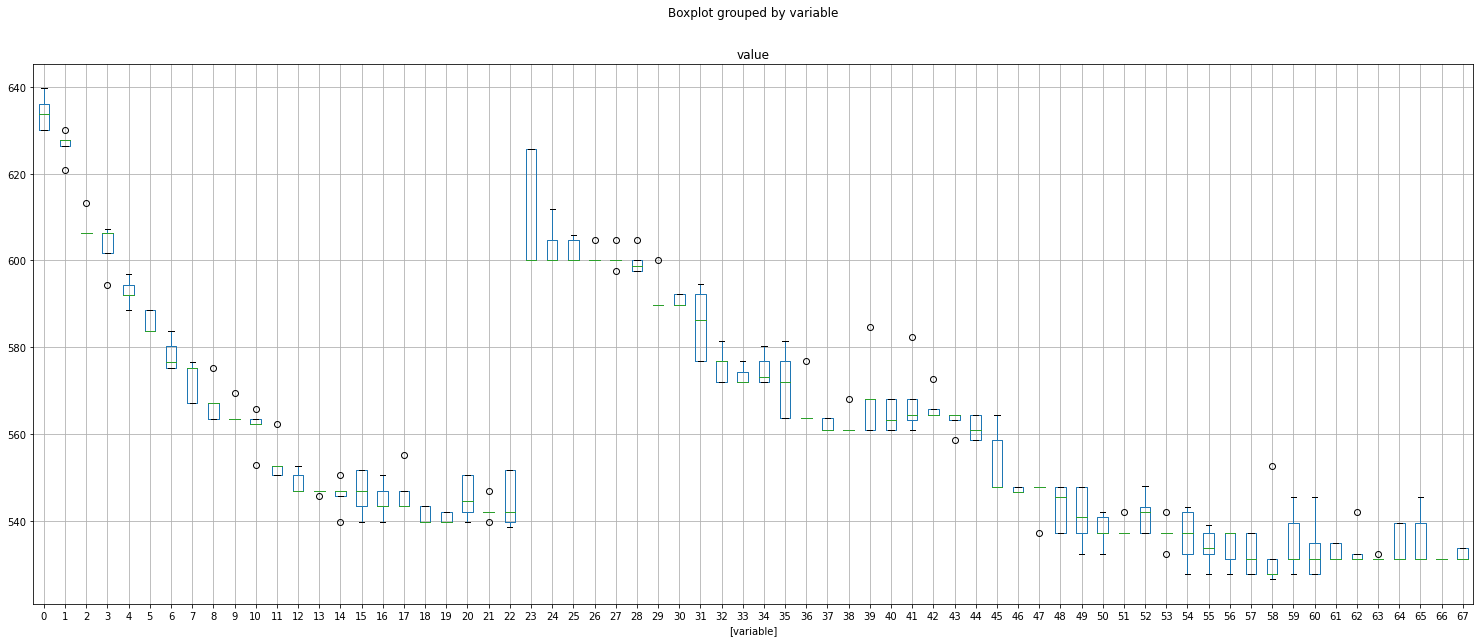

In [47]:
#fig = df2.loc[((df2['variable'] >= 0)&(df2['variable'] <= 1000))].boxplot(by='variable').get_figure()

#fig.savefig('test22.png')

<AxesSubplot:title={'center':'value'}, xlabel='[variable]'>

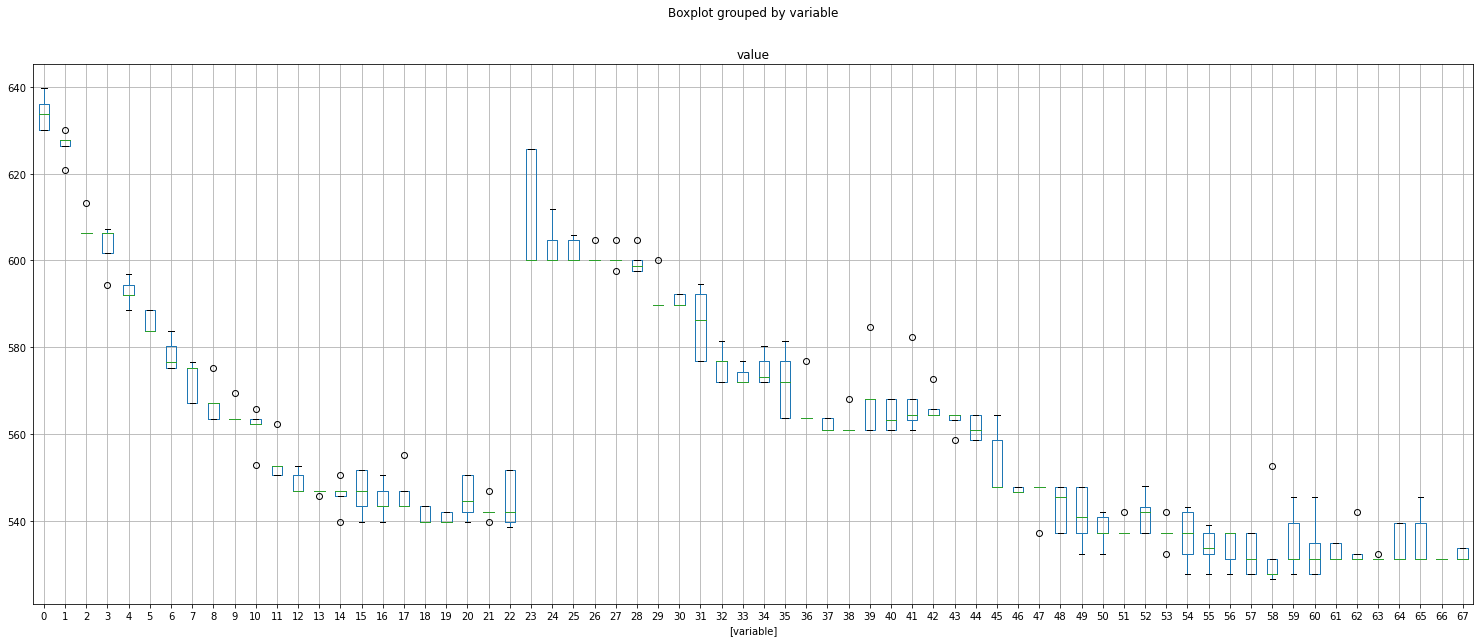

In [43]:
#df2.loc[((df2['variable'] >= 0)&(df2['variable'] <= 1000))].boxplot(by='variable')